In [1]:
import os 
import pandas as pd
from imp import reload
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio
import numpy as np

In [ ]:
# update the wd path to be able to laod the modules
# os.getcwd()
os.chdir('..')

In [11]:
# load the modules
import cities_indicators
from cities_indicators.core import get_indicators, Indicator
from cities_indicators.city import SupportedCity, City
from cities_indicators.layers.tropical_tree_cover import TropicalTreeCover
from cities_indicators.layers.esa_world_cover import EsaWorldCover, EsaWorldCoverClass

# Get city boundary

In [12]:
# declare city

geo_name = "IDN-Jakarta"
admin_level= 4

city = SupportedCity(geo_name)

In [14]:
# get boundaries

# get city data attributes
city_data = City(city = city, admin_level = admin_level)

city_boundaries =city_data.boundaries
city_boundaries.head()

,index,geo_id,geo_level,geo_name,geo_parent_name,creation_date,geometry
0,0,IDN-Jakarta_ADM-4_1,ADM-4,Cikini,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.83293 -6.18731, 106.83334 ..."
1,1,IDN-Jakarta_ADM-4_2,ADM-4,Gondangdia,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.82070 -6.19433, 106.82237 ..."
2,2,IDN-Jakarta_ADM-4_3,ADM-4,Karet,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.81840 -6.21460, 106.81856 ..."
3,3,IDN-Jakarta_ADM-4_4,ADM-4,Serdang,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.85523 -6.16009, 106.85690 ..."
4,4,IDN-Jakarta_ADM-4_5,ADM-4,Duri Selatan,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.80137 -6.15694, 106.80139 ..."


In [15]:
# Rastrize a city
city_raster = city_data.to_raster(resolution = 0.001)
city_raster

<xarray.DataArray 'index' (y: 286, x: 289)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 -6.09 -6.091 -6.091 -6.093 ... -6.373 -6.373 -6.375
  * x            (x) float64 106.7 106.7 106.7 106.7 ... 107.0 107.0 107.0 107.0
    spatial_ref  int32 0
Attributes:
    name:        index
    long_name:   index
    _FillValue:  nan

<AxesSubplot:>

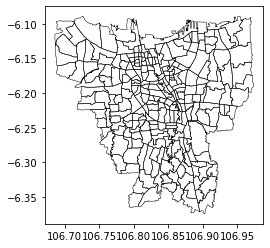

In [16]:
# plot
city_boundaries.plot(color='None',
                    edgecolor='black',
                     linewidth=0.5)

# Get city layer

## Tropical Tree Cover

In [17]:
# get layer data
city_layer_TropicalTreeCover = TropicalTreeCover().read(city = city_data, resolution = 0.0001)
city_layer_TropicalTreeCover

<xarray.DataArray (y: 2854, x: 2885)>
array([[nan, nan, nan, ...,  0.,  0., 50.],
       [nan, nan, nan, ...,  0.,  0., 40.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * x            (x) float64 106.7 106.7 106.7 106.7 ... 107.0 107.0 107.0 107.0
  * y            (y) float64 -6.089 -6.089 -6.089 ... -6.374 -6.374 -6.374
    band         int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

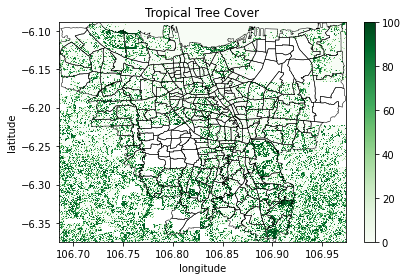

In [18]:
# plot layer data
city_boundaries.plot(color='None',
                    edgecolor='black',
                     linewidth=0.5)
city_layer_TropicalTreeCover.plot.imshow(cmap=plt.cm.Greens)
plt.title("Tropical Tree Cover")
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.tight_layout()
plt.show()

## Esa world cover

In [19]:
built_class_name = EsaWorldCoverClass.BUILT_UP

In [20]:
city_layer_built_up_land = EsaWorldCover().read(city = city_data, 
                                                resolution = 0.0001,
                                               land_cover_class = built_class_name)
city_layer_built_up_land

<xarray.DataArray (y: 2854, x: 2885)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, 50., 50., ..., 50., 50., 50.],
       [nan, 50., 50., ..., 50., 50., 50.],
       ...,
       [nan, 50., 50., ..., nan, nan, nan],
       [nan, 50., 50., ..., nan, nan, nan],
       [nan, 50., nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 106.7 106.7 106.7 106.7 ... 107.0 107.0 107.0 107.0
  * y            (y) float64 -6.089 -6.089 -6.089 ... -6.374 -6.374 -6.374
    band         int32 1
    spatial_ref  int32 0
Attributes:
    algorithm_version:   V1.0.0
    AREA_OR_POINT:       Area
    copyright:           ESA WorldCover project 2020 / Contains modified Cope...
    creation_time:       2021-10-12 16:51:26.705020
    legend:              10  Tree cover\n    20  Shrubland\n    30  Grassland...
    license:             CC-BY 4.0 - https://creativecommons.org/licenses/by/...
    OVR_RESAMPLING_ALG:  MODE
    product_crs:         EPSG:4326
    product_grid:        3x3 degree tiling grid
    product_tile:        S09E105
    product_type:        LandCover Map
    product_version:     V1.0.0
    reference:           https://esa-worldcover.org
    time_end:            2020-12-31T23:59:59Z
    time_start:          2020-01-01T00:00:00Z
    title:               ESA WorldCover product at 10m resolution for year 2020
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0

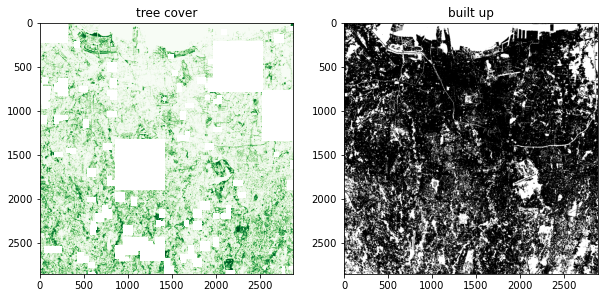

In [21]:
# Plot 
f = plt.figure(figsize=[10, 15])
f.add_subplot(1, 2, 1)
plt.title("tree cover")
plt.imshow(city_layer_TropicalTreeCover,cmap='Greens')
f.add_subplot(1, 2, 2)
plt.title("built up")
plt.imshow(np.isnan(city_layer_built_up_land), cmap='gray')
plt.show()

# Calculate indicators

## One indicator * One city

In [22]:
# Built up with tree cover
indicators = get_indicators(cities=[city], 
                            indicators=[Indicator.BUILT_LAND_WITH_TREE_COVER])

indicators_df = pd.DataFrame(indicators[0])
indicators_df.head()

,geo_id,geo_level,geo_name,geo_parent_name,creation_date,geometry,percent_tree_cover_in_built_up_land
index,,,,,,,
0.0,IDN-Jakarta_ADM-4_1,ADM-4,Cikini,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.83293 -6.18731, 106.83334 ...",0.253016
1.0,IDN-Jakarta_ADM-4_2,ADM-4,Gondangdia,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.82070 -6.19433, 106.82237 ...",0.485168
2.0,IDN-Jakarta_ADM-4_3,ADM-4,Karet,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.81840 -6.21460, 106.81856 ...",0.344495
3.0,IDN-Jakarta_ADM-4_4,ADM-4,Serdang,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.85523 -6.16009, 106.85690 ...",0.045209
4.0,IDN-Jakarta_ADM-4_5,ADM-4,Duri Selatan,IDN-Jakarta,2022-06-27,"MULTIPOLYGON (((106.80137 -6.15694, 106.80139 ...",0.051940


## One indicator * Multiple cities